In [20]:
import pandas as pd
import numpy as np
from utils.connect import GetQuery, GetPrices, GetRussell, GetVolume
from utils.optimizer import GainyOptimizer
from utils.my_utils import DateFromStr, DateToStr
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from utils.portfolio import ReturnPortfolio

In [2]:
# Get Russell 1000
tickers = GetRussell(show_index=True)
tickers = tickers.loc[tickers['index']=='R1000'].Code
tickers

0        AIZ
1         AL
2        DNB
3       BERY
4       MNST
        ... 
1005    BALL
1006    EHAB
1007    RITM
1008     RXO
1009     GEN
Name: Code, Length: 1010, dtype: object

In [3]:
# Keep tradable
trade = pd.read_csv("./Instruments List_PROD_NOV2022.csv").Symbol
tickers = [x for x in tickers if x in list(trade)]


In [16]:
# Calculate last 90 days volatility

def FilterLowVol(tickers, DT):
    
    start_date = DateFromStr(DT) - relativedelta(days=90)
    price_start_date = DateFromStr(DT) - relativedelta(days=95) # Extra days to avoid NaNs
    
    
    # Get prices and volume
    pr_vol = GetVolume(tickers, price_start_date, DT)
    pr_vol['doll_vol'] = pr_vol.volume * pr_vol.unadj_price
    
    # Filter (keep avg volume >$100mln, min_volume>$2mln, price >$10)
    vol_filter1 = pr_vol.loc[pd.to_datetime(pr_vol.date).dt.date>start_date].groupby('ticker').doll_vol.mean()
    vol_filter1 = vol_filter1[vol_filter1>100e6]
    
    vol_filter2 = pr_vol.loc[pd.to_datetime(pr_vol.date).dt.date>start_date].groupby('ticker').doll_vol.min()
    vol_filter2 = vol_filter2[vol_filter2>2e6]
    
    
    last_pr = pr_vol.loc[(pr_vol.date == pr_vol.date.max()) & (pr_vol.unadj_price>10)]
    
    filtered_tickers = [x for x in vol_filter1.index if x in vol_filter2.index]
    filtered_tickers = [x for x in filtered_tickers if x in list(last_pr.ticker)]
    
    
    # Calculate last 90 days volatility
    rets = pr_vol[['date', 'ticker', 'price']].pivot(index='date', columns='ticker', values='price')
    rets.index = pd.to_datetime(rets.index)
    rets = rets[filtered_tickers].pct_change().loc[start_date:,:]
    volat = pd.DataFrame(rets.std() * (250**0.5), columns=['vol']).reset_index().sort_values('vol')
    
    
    # Keep top-30
    out = volat.iloc[0:30].ticker
    
    return list(out)
    

# Optimization backtest

In [44]:
params = {'bounds': (0.01, 0.3), 'penalties': {'hs': 0.005, 'hi': 0.005, 'b': 0.05}}

In [60]:
start_date = '2007-01-01'
end_date = '2022-12-20'
rebalance_dates = pd.date_range(start_date,end_date, freq='BM').strftime("%Y-%m-%d").tolist()


In [92]:
def RecurringOptimization(tickers, dt, params):
    ticker_list = FilterLowVol(tickers, d)
    
    i=0
    while i<20:
        i+=1
        optimizer = GainyOptimizer(ticker_list, d, benchmark='SPY', lookback=9)
        opt_res = optimizer.OptimizePortfolioRiskBudget(params=params)
        
        remove = [ticker for ticker, weight in opt_res.items() if weight<=0.01]
        
        if len(remove)==0:
            break
        else:
            ticker_list = list(set(ticker_list) - set(remove))
    
    return opt_res
        

In [93]:
RecurringOptimization(tickers, "2022-12-01", params)

{'YUM': 0.12468354759559208,
 'VMW': 0.12432048431399824,
 'INCY': 0.09787664318922008,
 'MDLZ': 0.08390843900367852,
 'SGFY': 0.07857029402778015,
 'RSG': 0.07500746414446731,
 'CME': 0.07386179247539416,
 'ORLY': 0.07104616868662735,
 'KO': 0.04739769496213314,
 'STZ': 0.04715154103682141,
 'WM': 0.043172192251501616,
 'PEP': 0.04289422746371739,
 'PG': 0.0426433489151528,
 'MCD': 0.029707407759749623,
 'TRV': 0.01775875417416624}

In [94]:
weights = pd.DataFrame()
for d in tqdm(rebalance_dates):
    opt_res = RecurringOptimization(tickers, d, params)
    weights = pd.concat([weights, pd.DataFrame(opt_res, index=[d])])
    

  3%|█▎                                         | 6/191 [00:48<21:11,  6.87s/it]WARNING:root:
The following tickers have less than 80% of price observations: ['LULU']
They will be dropped
We do not support the following tickers ['LULU'].
They will be dropped from the optimization

The following tickers have less than 80% of price observations: ['LULU']
They will be dropped
We do not support the following tickers ['LULU'].
They will be dropped from the optimization

The following tickers have less than 80% of price observations: ['LULU']
They will be dropped
We do not support the following tickers ['LULU'].
They will be dropped from the optimization

The following tickers have less than 80% of price observations: ['LULU']
They will be dropped
We do not support the following tickers ['LULU'].
They will be dropped from the optimization

The following tickers have less than 80% of price observations: ['LULU']
They will be dropped
We do not support the following tickers ['LULU'].
They will 

We do not support the following tickers ['GTES'].
They will be dropped from the optimization

The following tickers have less than 80% of price observations: ['GTES']
They will be dropped
We do not support the following tickers ['GTES'].
They will be dropped from the optimization

The following tickers have less than 80% of price observations: ['GTES']
They will be dropped
We do not support the following tickers ['GTES'].
They will be dropped from the optimization

The following tickers have less than 80% of price observations: ['GTES']
They will be dropped
We do not support the following tickers ['GTES'].
They will be dropped from the optimization

 84%|██████████████████████████████████▌      | 161/191 [19:20<04:54,  9.82s/it]WARNING:root:
The following tickers have less than 80% of price observations: ['ACI']
They will be dropped
We do not support the following tickers ['ACI'].
They will be dropped from the optimization

The following tickers have less than 80% of price observations

In [108]:
weights

,DD,MCD,LLY,VZ,JPM,UPS,MSFT,IBM,HIG,MET,...,AME,WRB,FHN,ATO,SWCH,VMW,LW,CI,MOH,SGFY
2007-01-31,0.106684,0.103455,0.099477,0.097822,0.091482,0.084049,0.074148,0.067788,0.067561,0.057174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-28,0.112005,0.108871,0.079421,NaN,0.097973,0.090830,NaN,0.080147,0.074387,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-30,NaN,0.087187,0.092692,NaN,NaN,0.091050,NaN,0.115108,0.114720,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-30,NaN,0.086079,0.120034,NaN,NaN,0.117916,NaN,NaN,0.113914,0.075672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-31,NaN,NaN,0.082681,NaN,NaN,0.067550,NaN,NaN,NaN,0.075538,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-29,NaN,0.195624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.06173,0.169832,NaN,NaN,NaN,NaN,NaN
2022-08-31,NaN,0.027013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.110548,NaN,NaN,NaN,NaN
2022-10-31,NaN,0.056970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.121815,0.110287,0.089303,0.052528,NaN


In [109]:
rets = GetPrices(weights.columns, "2007-01-01", "2022-12-22").pct_change()


In [110]:
w = weights
w.index = pd.to_datetime(w.index)

In [111]:
port = ReturnPortfolio(rets, w)
port

,Portfolio
2007-02-01,0.005832
2007-02-02,-0.000423
2007-02-05,-0.000966
2007-02-06,0.003429
2007-02-07,0.000339
...,...
2022-12-16,-0.005841
2022-12-19,-0.006206
2022-12-20,0.001172
2022-12-21,0.008840


In [112]:
bm = GetPrices("SPY", "2007-01-01", "2022-12-22").pct_change()

In [113]:
df = pd.merge(port, bm, left_index=True, right_index=True)
df

,Portfolio,SPY
2007-02-01,0.005832,0.005983
2007-02-02,-0.000423,0.001383
2007-02-05,-0.000966,0.000276
2007-02-06,0.003429,0.000277
2007-02-07,0.000339,0.002208
...,...,...
2022-12-16,-0.005841,-0.016323
2022-12-19,-0.006206,-0.008480
2022-12-20,0.001172,0.001368
2022-12-21,0.008840,0.014952


<AxesSubplot:>

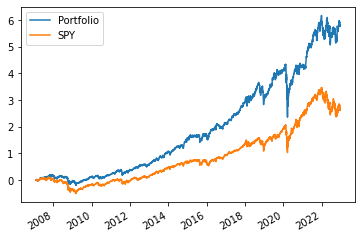

In [114]:
((1+df).cumprod()-1).plot()

<AxesSubplot:>

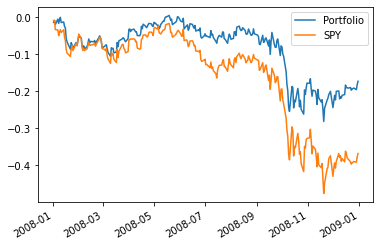

In [115]:
((1+df.loc["2008"]).cumprod()-1).plot()

<AxesSubplot:>

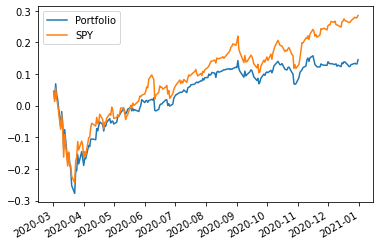

In [116]:
((1+df.loc["2020-03":"2020-12"]).cumprod()-1).plot()

<AxesSubplot:>

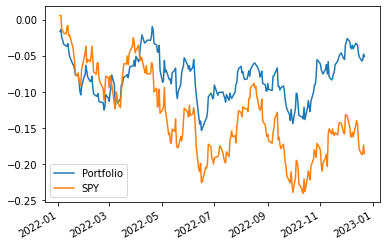

In [117]:
((1+df.loc["2022"]).cumprod()-1).plot()

In [118]:
df.mean()*250

Portfolio    0.133230
SPY          0.101305
dtype: float64

In [119]:
df.std()*(250**0.5)

Portfolio    0.163842
SPY          0.204463
dtype: float64

In [120]:
today_weight = pd.DataFrame(weights.iloc[-1].dropna())
today_weight.columns=['weight']
today_weight.sort_values('weight', ascending=False)

,weight
YUM,0.124684
VMW,0.124320
INCY,0.097877
MDLZ,0.083908
SGFY,0.078570
RSG,0.075007
CME,0.073862
ORLY,0.071046
KO,0.047398
STZ,0.047152
